# This script handles S2 band norm for inference

## Imports

In [28]:
import os
import re
import subprocess
from collections import defaultdict
import numpy as np
import rasterio
from rasterio.merge import merge
from rasterio.warp import reproject, Resampling
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import glob
import json
from tqdm import tqdm

#import geopandas as gpd
import pandas as pd

%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')

import utils.basics as bsc 
import utils.plotting as pt
import utils.processing as proc

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## load the data

In [ ]:
from types import SimpleNamespace

# PATH - Definitions
# can be refactored
# === INPUT Paths ===

PATH_SITE1 = '../data/01_input_pipeline/01_Ebrach' 
PATH_SITE2 = '../data/01_input_pipeline/02_Wald'
PATH_SITE3 = '../data/01_input_pipeline/03_Berch'
PATH_SITE4 = '../data/01_input_pipeline/04_Munich'
PATH_SITE5 = '../data/01_input_pipeline/05_Oberland'

PATH_SITE1F = '../data/01_input_pipeline/01_Ebrach/01_' 
PATH_SITE2F = '../data/01_input_pipeline/02_Wald/02_'
PATH_SITE3F = '../data/01_input_pipeline/03_Berch/03_'
PATH_SITE4F = '../data/01_input_pipeline/04_Munich/04_'
PATH_SITE5F = '../data/01_input_pipeline/05_Oberland/05_'

CHM_SUFFIX = 'CHM.tif'  # 'ALS_GT' or 'ALS_GT_Processed'
DEM_SUFFIX = 'DEM10.tif'  # 'DEM' or 'DEM_Processed'
DLT_SUFFIX = 'DLT_P.tif'  # 'DLTM' or 'DLTM_Processed'
FMASK_SUFFIX = 'FMA_P.tif'  # 'ForestMask' or 'ForestMask_Processed'

# Define the seasons
SEASONS = ['spring', 'summer', 'autumn']

# Build paths to stacked S2 images for each season for each site
S2_STACKED_PATHS = {
    site: {
        season: os.path.join(site, 'S2', season, 'S2_stacked.tif')
        for season in SEASONS
    }
    for site in [PATH_SITE1, PATH_SITE2, PATH_SITE3, PATH_SITE4, PATH_SITE5]
}

# NAMESPACE FOR EASY HANDLING:

SITE1 = SimpleNamespace(
    NAME="Ebrach",
    PATH=PATH_SITE1,
    PATHF=PATH_SITE1F,
    CHM=os.path.join(PATH_SITE1F + CHM_SUFFIX),
    DEM=os.path.join(PATH_SITE1F + DEM_SUFFIX),
    DLT=os.path.join(PATH_SITE1F + DLT_SUFFIX),
    FMASK=os.path.join(PATH_SITE1F + FMASK_SUFFIX),
    S2=SimpleNamespace(**S2_STACKED_PATHS[PATH_SITE1])
)

SITE2 = SimpleNamespace(
    NAME="Waldbrunn",
    PATH=PATH_SITE2,
    PATHF=PATH_SITE2F,
    CHM=os.path.join(PATH_SITE2F + CHM_SUFFIX),
    DEM=os.path.join(PATH_SITE2F + DEM_SUFFIX),
    DLT=os.path.join(PATH_SITE2F + DLT_SUFFIX),
    FMASK=os.path.join(PATH_SITE2F + FMASK_SUFFIX),
    S2=SimpleNamespace(**S2_STACKED_PATHS[PATH_SITE2])
)

SITE3 = SimpleNamespace(
    NAME="Berchtesgaden",
    PATH=PATH_SITE3,
    PATHF=PATH_SITE3F,
    CHM=os.path.join(PATH_SITE3F + CHM_SUFFIX),
    DEM=os.path.join(PATH_SITE3F + DEM_SUFFIX),
    DLT=os.path.join(PATH_SITE3F + DLT_SUFFIX),
    FMASK=os.path.join(PATH_SITE3F + FMASK_SUFFIX),
    S2=SimpleNamespace(**S2_STACKED_PATHS[PATH_SITE3])
)
SITE4 = SimpleNamespace(
    NAME="Munich",
    PATH=PATH_SITE4,
    PATHF=PATH_SITE4F,
    CHM=os.path.join(PATH_SITE4F + CHM_SUFFIX),
    #DEM=os.path.join(PATH_SITE4F + DEM_SUFFIX), #can be extended if needed
    #DLT=os.path.join(PATH_SITE4F + DLT_SUFFIX),  #can be extended if needed
    FMASK=os.path.join(PATH_SITE4F + FMASK_SUFFIX),
    S2=SimpleNamespace(**S2_STACKED_PATHS[PATH_SITE4])
)
SITE5 = SimpleNamespace(
    NAME="Oberland",
    PATH=PATH_SITE5,
    PATHF=PATH_SITE5F,
    CHM=os.path.join(PATH_SITE5F + CHM_SUFFIX),
    #DEM=os.path.join(PATH_SITE5F + DEM_SUFFIX),  #can be extended if needed
    #DLT=os.path.join(PATH_SITE5F + DLT_SUFFIX),   #can be extended if needed
    FMASK=os.path.join(PATH_SITE5F + FMASK_SUFFIX),
    S2=SimpleNamespace(**S2_STACKED_PATHS[PATH_SITE5])
)


In [30]:
# this is how our namespace looks like, we'll add the S2_norm later.
SITE4

namespace(NAME='Munich',
          PATH='../data/01_input_pipeline/04_Munich',
          PATHF='../data/01_input_pipeline/04_Munich/04_',
          CHM='../data/01_input_pipeline/04_Munich/04_CHM.tif',
          FMASK='../data/01_input_pipeline/04_Munich/04_FMA_P.tif',
          S2=namespace(spring='../data/01_input_pipeline/04_Munich/S2/spring/S2_stacked.tif',
                       summer='../data/01_input_pipeline/04_Munich/S2/summer/S2_stacked.tif',
                       autumn='../data/01_input_pipeline/04_Munich/S2/autumn/S2_stacked.tif'))

In [ ]:
# s2_np3, als_np3, band_names = bsc.load_rasters(SITE3.S2.spring, SITE3.CHM, verbose=False)
s2_np4, als_np4, band_names = bsc.load_rasters(SITE4.S2.spring, SITE4.CHM, verbose=False)
s2_np5, als_np5, band_names = bsc.load_rasters(SITE5.S2.spring, SITE5.CHM, verbose=False)

## plot the S2 channel histograms

,B1_BLU_Q50,B2_BNR_Q50,B3_EVI_Q50,B4_GRN_Q50,B5_NBR_Q50,B6_NDV_Q50,B7_NIR_Q50,B8_RE1_Q50,B9_RE2_Q50,B10_RE3_Q50,B11_RED_Q50,B12_SW1_Q50,B13_SW2_Q50
P0,-9999.00,-9999.00,-9999.00,-9999.00,-9999.00,-9999.00,-9999.0,-9999.00,-9999.00,-9999.00,-9999.00,-9999.00,-9999.00
P0.1,204.00,212.00,-2077.59,273.47,-4580.21,-5269.96,200.0,316.47,215.47,227.47,217.47,214.00,140.00
P25,445.00,1315.00,788.00,626.00,-347.00,1531.00,1403.0,934.00,1274.00,1339.00,596.00,1491.00,1121.00
P50,607.00,1697.00,1519.00,776.00,827.00,2897.00,1738.0,1067.00,1538.00,1643.00,841.00,1669.00,1371.00
P75,826.00,2197.00,2797.00,988.00,2637.00,5013.00,2208.0,1232.00,1878.00,2058.00,1108.00,1885.00,1628.00
P95,1304.00,3057.00,4730.00,1482.00,4878.00,7249.00,3054.0,1647.00,2456.00,2792.00,1611.00,2316.00,2051.55
P99.9,2811.59,4755.53,7441.06,3068.12,6349.00,8370.00,4881.0,3143.00,3674.00,4417.53,3359.53,3613.12,3262.00
P100,4904.00,5874.00,8012.00,5549.00,7011.00,8871.00,5425.0,5570.00,5566.00,5502.00,5630.00,4819.00,4894.00
NaN Ratio,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00


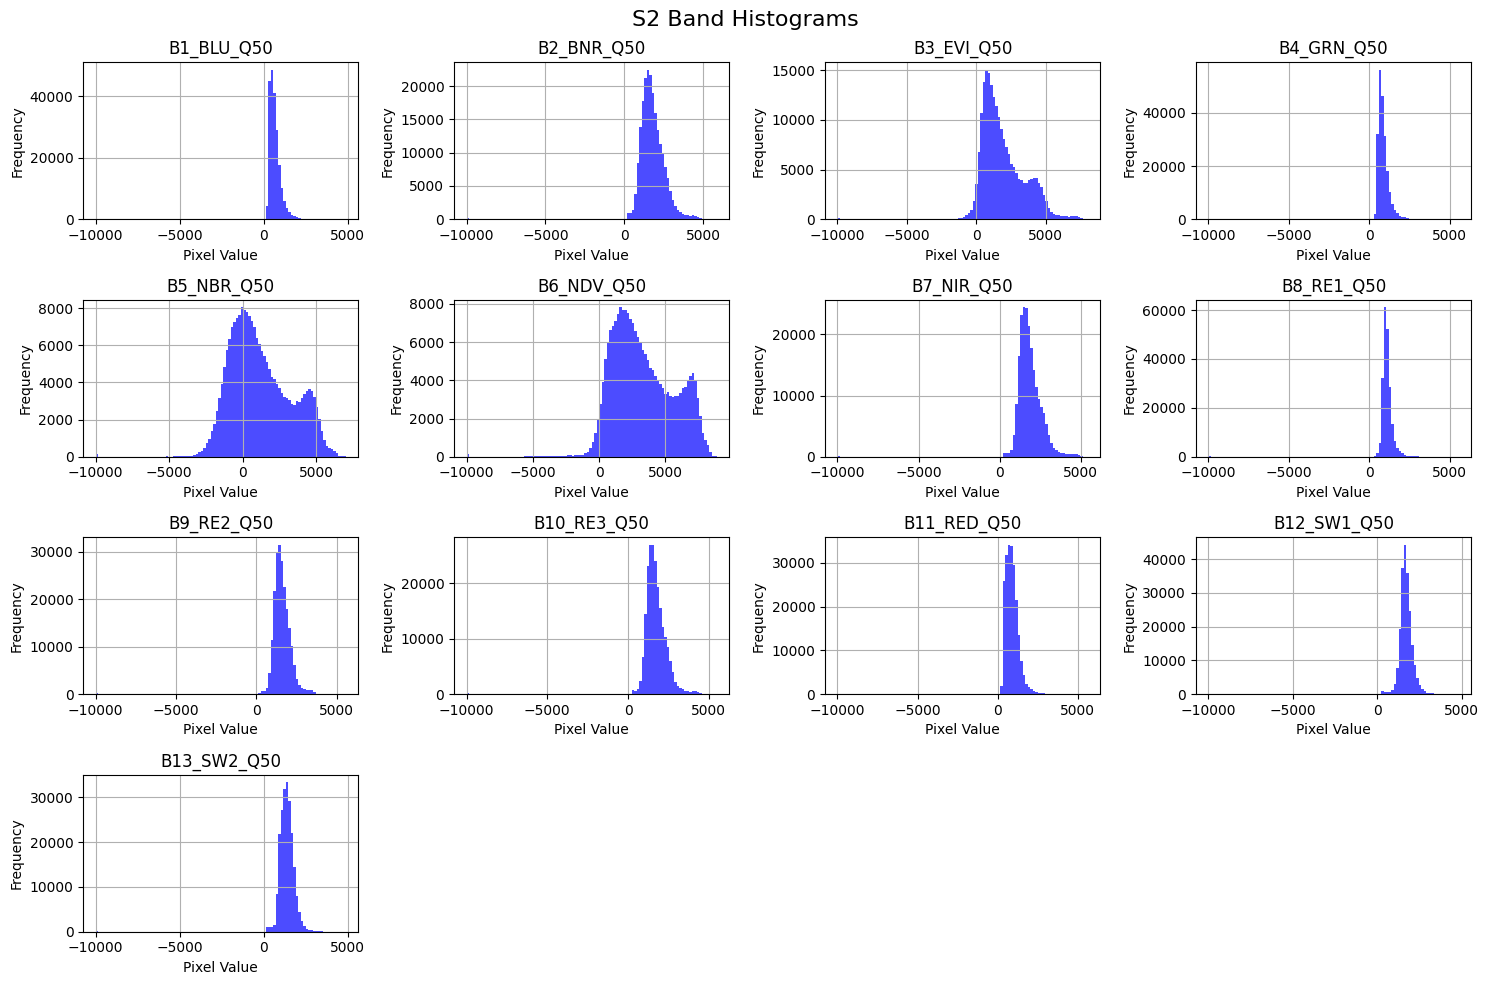

In [6]:
pt.plot_s2_histograms_and_percentiles(s2_np4, num_bands=13, band_names=band_names)

⚡️ we observe: many missing values (-9999.0) and real values are just within a small range. --> we need to normalize! 

## Normalize S2 channels

In [34]:
# takes around 50sec to normalize everything:
for site in tqdm([SITE1, SITE2, SITE3,SITE4, SITE5], desc="Sites"):
    for season in SEASONS:
        if hasattr(site.S2, season):
            proc.normalize_and_save_s2_geotiff(getattr(site.S2, season), site, season, override=False)


Sites: 100%|██████████| 5/5 [00:00<00:00, 2223.21it/s]

✅ Normalized file already exists: ../data/01_input_pipeline/01_Ebrach/S2/spring/S2_stacked_norm.tif. Namespace updated.
✅ Normalized file already exists: ../data/01_input_pipeline/01_Ebrach/S2/summer/S2_stacked_norm.tif. Namespace updated.
✅ Normalized file already exists: ../data/01_input_pipeline/01_Ebrach/S2/autumn/S2_stacked_norm.tif. Namespace updated.
✅ Normalized file already exists: ../data/01_input_pipeline/02_Wald/S2/spring/S2_stacked_norm.tif. Namespace updated.
✅ Normalized file already exists: ../data/01_input_pipeline/02_Wald/S2/summer/S2_stacked_norm.tif. Namespace updated.
✅ Normalized file already exists: ../data/01_input_pipeline/02_Wald/S2/autumn/S2_stacked_norm.tif. Namespace updated.
✅ Normalized file already exists: ../data/01_input_pipeline/03_Berch/S2/spring/S2_stacked_norm.tif. Namespace updated.
✅ Normalized file already exists: ../data/01_input_pipeline/03_Berch/S2/summer/S2_stacked_norm.tif. Namespace updated.
✅ Normalized file already exists: ../data/01_inp

In [35]:
s2_1n, desc = bsc.read_multiband_tif_as_stack(SITE4.S2_norm.summer, bands=13, channels=5)

In [36]:
s2_1n.shape
s2_1nr = s2_1n.reshape(13*5,s2_1n.shape[2],s2_1n.shape[3])

In [37]:
s2_1nr.shape

(65, 530, 399)

## now histograms should look much better.

,B1_BLU_Q50,B2_BLU_Q50_a,B3_BLU_Q50_b,B4_BLU_Q50_c,B5_BLU_Q50_d,B6_BNR_Q50,B7_BNR_Q50_a,B8_BNR_Q50_b,B9_BNR_Q50_c,B10_BNR_Q50_d,B11_EVI_Q50,B12_EVI_Q50_a,B13_EVI_Q50_b
P0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
P0.1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
P25,0.09,0.09,0.09,0.09,0.09,0.27,0.27,0.27,0.27,0.27,0.14,0.14,0.14
P50,0.16,0.16,0.16,0.16,0.16,0.36,0.36,0.36,0.36,0.36,0.26,0.26,0.26
P75,0.24,0.24,0.24,0.24,0.24,0.50,0.50,0.50,0.50,0.50,0.49,0.49,0.49
P95,0.42,0.42,0.42,0.42,0.42,0.72,0.72,0.72,0.72,0.72,0.79,0.79,0.79
P99.9,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
P100,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
NaN Ratio,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.02,0.02


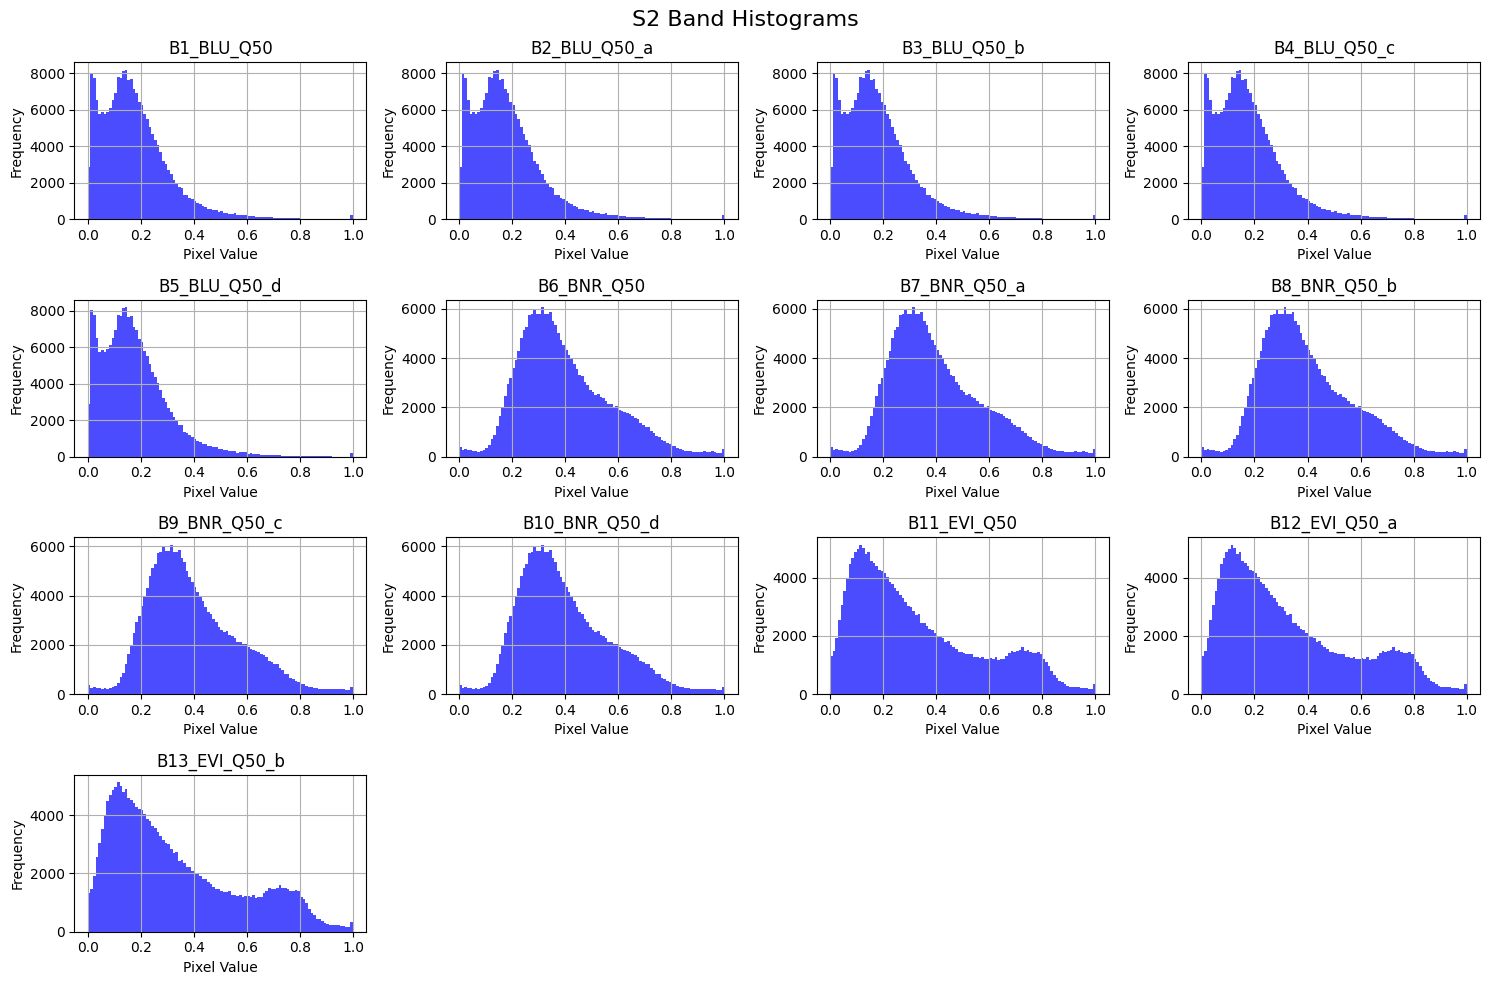

In [38]:
pt.plot_s2_histograms_and_percentiles(s2_1nr, num_bands=13, band_names=desc)

# ALS Normalization --> adaption for inference

pipeline expects a normalized chm. we just have a pseudo chm with all values to 0.

In [17]:
# DO NORMALIZATION OF ALS WHERE FOREST MASK IS 1
NORMPARAMS = proc.compute_chm_norm_params(SITE1, SITE2, SITE3)

In [18]:
NORMPARAMS.info

namespace(description='CHM normalization parameters',
          encoding='001: Third Site only, 010: Second Site, 100: First Site',
          version='1.1')

In [19]:
NORMPARAMS.chm

namespace(_100={'mu': 29.136810302734375,
                'std': 5.059322357177734,
                'n': 424127},
          _010={'mu': 27.330501556396484,
                'std': 6.319409370422363,
                'n': 331027},
          _001={'mu': 29.6536808013916, 'std': 9.09404182434082, 'n': 752512},
          _110={'mu': 28.23365592956543,
                'std': 5.794953346252441,
                'n': 755154},
          _101={'mu': 29.395244598388672,
                'std': 7.363151550292969,
                'n': 1176639},
          _011={'mu': 28.49209213256836,
                'std': 7.916279315948486,
                'n': 1083539},
          _111={'mu': 28.706998825073242,
                'std': 7.0994954109191895,
                'n': 1507666},
          _eq={'mu': 28.706998825073242,
               'std': 7.0994954109191895,
               'n': 1507666})

In [83]:
import yaml

def namespace_to_dict(ns):
    if isinstance(ns, SimpleNamespace):
        return {k: namespace_to_dict(v) for k, v in ns.__dict__.items()}
    elif isinstance(ns, dict):
        return {k: namespace_to_dict(v) for k, v in ns.items()}
    elif isinstance(ns, np.ndarray):
        return ns.tolist()
    elif hasattr(ns, '__dict__'):
        return {k: namespace_to_dict(v) for k, v in ns.__dict__.items()}
    else:
        return ns

normparams_dict = namespace_to_dict(NORMPARAMS)

with open('../configs/normparams.yaml', 'w') as f:
    yaml.dump(normparams_dict, f)

In [23]:
proc.normalize_chm(SITE1, SITE4, SITE5, NORMPARAMS, jointnorm=True)

✅ ALS normalization complete.


In [25]:
SITE4

namespace(NAME='Munich',
          PATH='../data/01_input_pipeline/04_Munich',
          PATHF='../data/01_input_pipeline/04_Munich/04_',
          CHM='../data/01_input_pipeline/04_Munich/04_CHM.tif',
          FMASK='../data/01_input_pipeline/04_Munich/04_FMA_P.tif',
          S2=namespace(spring='../data/01_input_pipeline/04_Munich/S2/spring/S2_stacked.tif',
                       summer='../data/01_input_pipeline/04_Munich/S2/summer/S2_stacked.tif',
                       autumn='../data/01_input_pipeline/04_Munich/S2/autumn/S2_stacked.tif'),
          S2_norm=namespace(spring='../data/01_input_pipeline/04_Munich/S2/spring/S2_stacked_norm.tif',
                            summer='../data/01_input_pipeline/04_Munich/S2/summer/S2_stacked_norm.tif',
                            autumn='../data/01_input_pipeline/04_Munich/S2/autumn/S2_stacked_norm.tif'),
          CHM_norm='../data/01_input_pipeline/04_Munich/04_CHM_norm111.tif',
          CHM_norm_params={'mu': 28.706998825073242,
    

In [69]:
NORMPARAMS.chm

namespace(_001={'mu': 29.136810302734375,
                'std': 5.059322357177734,
                'n': 424127},
          _010={'mu': 27.330501556396484,
                'std': 6.319409370422363,
                'n': 331027},
          _100={'mu': 29.6536808013916, 'std': 9.09404182434082, 'n': 752512},
          _011={'mu': 28.23365592956543,
                'std': 5.794953346252441,
                'n': 755154},
          _101={'mu': 29.395244598388672,
                'std': 7.363151550292969,
                'n': 1176639},
          _110={'mu': 28.49209213256836,
                'std': 7.916279315948486,
                'n': 1083539},
          _111={'mu': 28.706998825073242,
                'std': 7.0994954109191895,
                'n': 1507666},
          _eq={'mu': 28.706998825073242,
               'std': 7.0994954109191895,
               'n': 1507666})

In [87]:
chm1 = bsc.read_tif_as_array(SITE1.CHM_norm)
chm2 = bsc.read_tif_as_array(SITE2.CHM_norm)
chm3 = bsc.read_tif_as_array(SITE3.CHM_norm)

✅ Loaded 01_CHM_norm111.tif: shape=(846, 1241), CRS=EPSG:25832, GSD=10.00 x 9.99 metre
Band names: ('nCHM_global',)
✅ Loaded 02_CHM_norm111.tif: shape=(1002, 815), CRS=EPSG:25832, GSD=9.99 x 10.00 metre
Band names: ('nCHM_global',)
✅ Loaded 03_CHM_norm111.tif: shape=(1870, 2129), CRS=EPSG:25832, GSD=10.00 x 10.00 metre
Band names: ('nCHM_global',)


## update yaml files

In [26]:
from types import SimpleNamespace
import pickle
import yaml

# Group all SITE and NORMPARAMS namespaces into one DATA_DIR namespace
DATA_DIR = SimpleNamespace(
    SITE1=SITE1,
    SITE2=SITE2,
    SITE3=SITE3,
    SITE4=SITE4,
    SITE5=SITE5,
    #NORMPARAMS=NORMPARAMS
)

# Save DATA_DIR namespace to a file using pickle
with open('DATA_DIR_INF.pkl', 'wb') as f:
    pickle.dump(DATA_DIR, f)

    # Convert DATA_DIR to a serializable dict
    def namespace_to_dict(ns):
        if isinstance(ns, SimpleNamespace):
            return {k: namespace_to_dict(v) for k, v in ns.__dict__.items()}
        elif isinstance(ns, dict):
            return {k: namespace_to_dict(v) for k, v in ns.items()}
        elif isinstance(ns, np.ndarray):
            return ns.tolist()
        elif hasattr(ns, '__dict__'):
            return {k: namespace_to_dict(v) for k, v in ns.__dict__.items()}
        else:
            return ns

    data_dir_dict = namespace_to_dict(DATA_DIR)

    # Save as YAML
    with open('../configs/datapaths_INF.yaml', 'w') as f:
        yaml.dump(data_dir_dict, f)